# Siamese Networks: _LeNet-5_, MNIST and PyTorch

[Reference](https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch/notebook)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, pickle

/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.12.1+cu102
Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu


In [3]:
# Define neural network hyper-parameters-
num_epochs = 50
batch_size = 256
learning_rate = 1e-4

In [4]:
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

# Define transforms-
transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [5]:
class Siamese_MNIST_Dataset(Dataset):
    def __init__(
        self, root,
        transform, train = True,
        download = False
    ):
        super(Siamese_MNIST_Dataset, self).__init__()
        
        # Retrieve MNIST dataset-
        self.mnist_dataset = torchvision.datasets.MNIST(
            root = root, train = train,
            transform = transforms_apply, download = download
        )
        
        # `self.mnist_dataset.data` has the shape (Nx28x28), where N is the number of
        # examples in MNIST dataset, a single example has the dimensions of
        # (28x28) for (WxH), where W and H are the width and the height of the image. 
        # However, every example should have (CxWxH) dimensions where C is the number 
        # of channels to be passed to the network. As MNIST contains gray-scale images, 
        # we add an additional dimension to corresponds to the number of channels.
        self.dataset = self.mnist_dataset.data.unsqueeze(1).clone()
        
        self.group_images()
        
    
    def group_images(self):
        """
        To ease data accessibility based on class, we group examples based on class.
        Every key in `grouped_imgs` corresponds to a class in MNIST dataset. For every key in 
        `grouped_imgs`, its value will contain all of the indices for the MNIST 
        dataset examples corresponding to that key.
        """
        # group examples based on class-
        self.grouped_imgs = {}

        for i in range(10):
            self.grouped_imgs[i] = np.where(self.mnist_dataset.targets == i)[0]
        
        
    def __len__(self):
        return self.mnist_dataset.data.shape[0]
    
    
    def __getitem__(self, index):
        """
        For every example, we will select two images. There are two cases, positive and negative examples:
            1. For positive examples, we will have two images from the same class.
            2. For negative examples, we will have two images from different classes.

        Given an index:

        1. if the index is even, we will pick the second image from the same class, but it won't be the same image
        we chose for the first class. This is used to ensure the positive example isn't trivial as the network would
        easily distinguish the similarity between same images. However, if the network were given two different
        images from the same class, the network will need to learn  the similarity between two different images
        representing the same class.

        2. If the index is odd, we will pick the second image from a different class than the first image.
        """
        # Choose some random class for the anchor image-
        selected_class = np.random.randint(low = 0, high = 10, size = None)

        # Choose a random index for the first image from the grouped indices using label of chosen class-
        random_idx_1 = np.random.randint(low = 0, high = self.grouped_imgs[selected_class].shape[0] - 1)

        # Choose index to retrieve fist image-
        idx_1 = self.grouped_imgs[selected_class][random_idx_1]

        # Retrieve first/anchor image-
        anchor = self.dataset[idx_1].clone().float()
        
        # Choose a random index for the second (positive) image-
        random_idx_2 = np.random.randint(low = 0, high = self.grouped_imgs[selected_class].shape[0] - 1, size = None)
    
        # Ensure that index of second (positive) image is not equal to the first (anchor) image-
        while random_idx_2 == random_idx_1:
            random_idx_2 = np.random.randint(low = 0, high = self.grouped_imgs[selected_class].shape[0] - 1, size = None)
    
        # Choose the index to retrieve the second (positive) image-
        idx_2 = self.grouped_imgs[selected_class][random_idx_2]
    
        # Retrieve second/positive image-
        positive = self.dataset[idx_2].clone().float()
        
        
        # Choose a different random class-
        diff_selected_class = np.random.randint(low = 0, high = 9, size = None)
    
        # Ensure that these two classes are different-
        while diff_selected_class == selected_class:
            diff_selected_class = np.random.randint(low = 0, high = 9, size = None)
    
        # Choose a random index for the second image in grouped indices using label of the chosen class-
        random_idx_3 = np.random.randint(low = 0, high = self.grouped_imgs[diff_selected_class].shape[0] - 1, size = None)
    
        # Choose index to retrieve second image-
        idx_3 = self.grouped_imgs[diff_selected_class][random_idx_3]
    
        # Retrieve third/negative image-
        negative = self.dataset[idx_3].clone().float()
        
        return anchor, positive, negative


In [ ]:
"""
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/.data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/.data', train = False,
        transform = transforms_apply
        )
"""

In [6]:
# Get train and test datasets for MNIST-
train_dataset = Siamese_MNIST_Dataset(
    root = '/home/arjun/Downloads/.data', train = True,
    transform = transforms_apply, download = True
)

test_dataset = Siamese_MNIST_Dataset(
    root = '/home/arjun/Downloads/.data', train = False,
    transform = transforms_apply, download = True
)

In [7]:
print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [8]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = True
        )

In [9]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


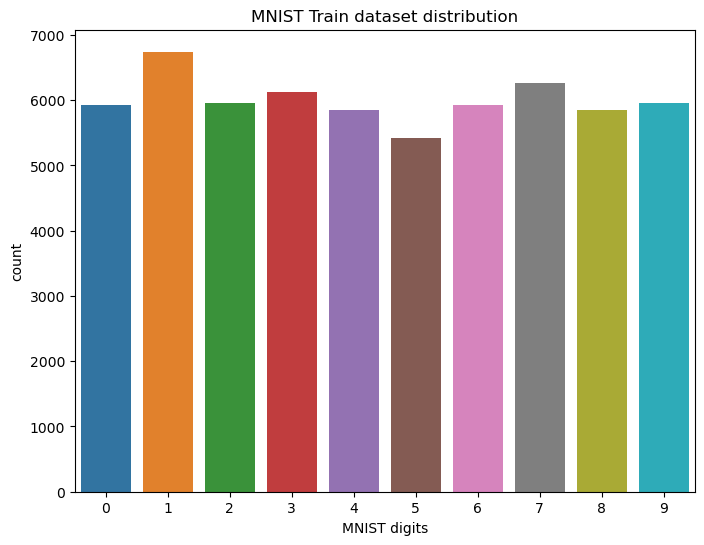

In [8]:
# Visualize MNIST train data distribution-

vals, cnt = np.unique(train_dataset.mnist_dataset.targets, return_counts = True)

plt.figure(figsize = (8, 6))
# plt.bar(x = vals, height = cnt)
sns.barplot(x = vals, y = cnt)
plt.xlabel("MNIST digits")
plt.ylabel("count")
plt.title("MNIST Train dataset distribution")
plt.show()

del cnt, vals

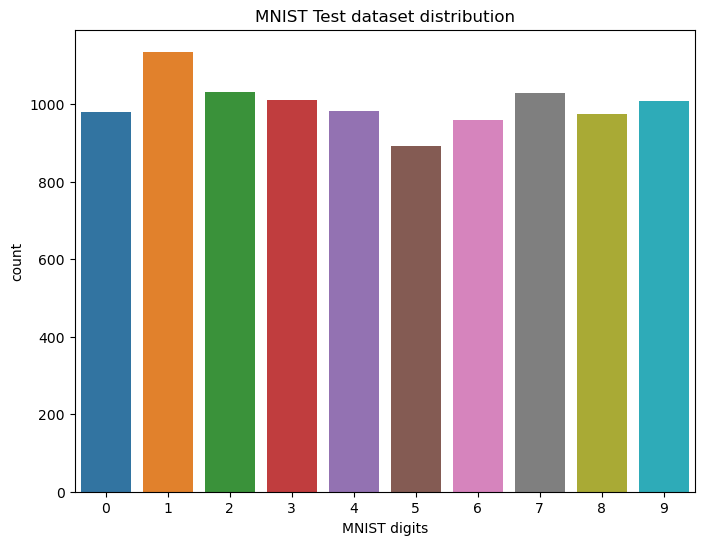

In [9]:
# Visualize MNIST testn data distribution-

vals, cnt = np.unique(test_dataset.mnist_dataset.targets, return_counts = True)

plt.figure(figsize = (8, 6))
# plt.bar(x = vals, height = cnt)
sns.barplot(x = vals, y = cnt)
plt.xlabel("MNIST digits")
plt.ylabel("count")
plt.title("MNIST Test dataset distribution")
plt.show()

del cnt, vals

In [12]:
# Get some random batch of training images & labels-
A, P, N = next(iter(train_loader))

In [13]:
A.shape, P.shape, N.shape

(torch.Size([256, 1, 28, 28]),
 torch.Size([256, 1, 28, 28]),
 torch.Size([256, 1, 28, 28]))

In [14]:
# De-normalize images (for visualization)-
A *= 255.0
P *= 255.0
N *= 255.0

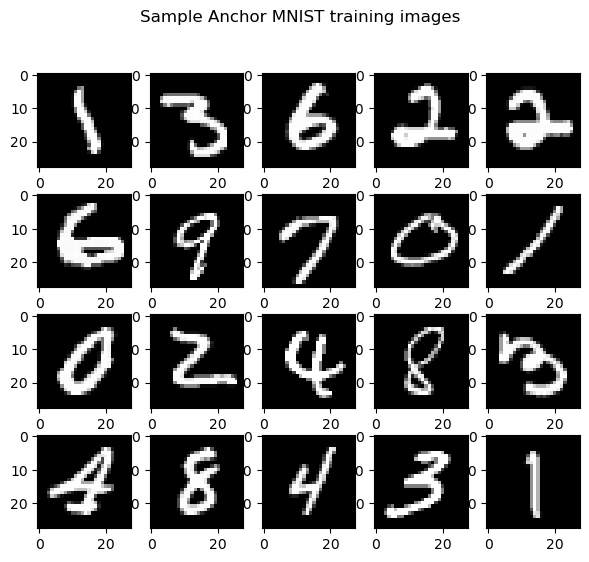

In [15]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(A[i][0], cmap = 'gray')
    
plt.suptitle("Sample Anchor MNIST training images")
plt.show()

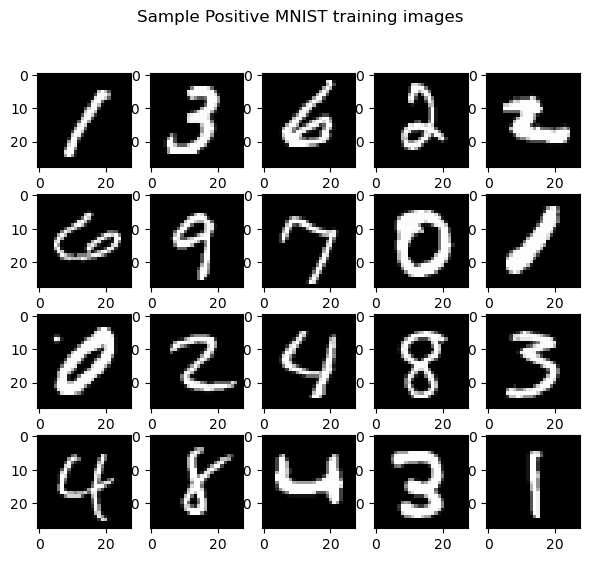

In [16]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(P[i][0], cmap = 'gray')
    
plt.suptitle("Sample Positive MNIST training images")
plt.show()

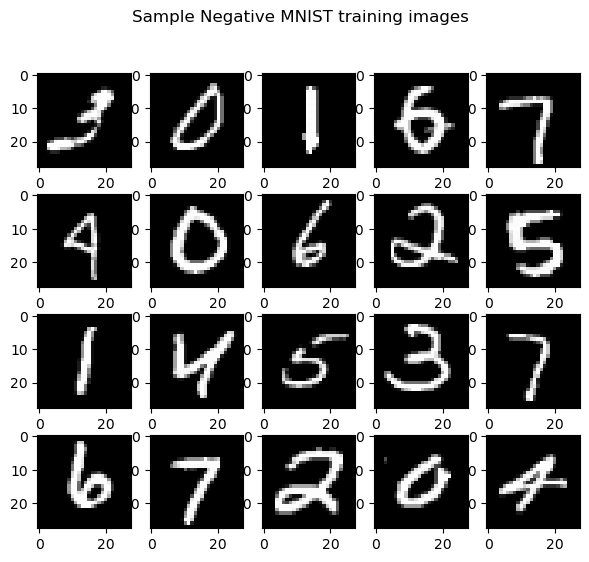

In [17]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(N[i][0], cmap = 'gray')
    
plt.suptitle("Sample Negative MNIST training images")
plt.show()

In [18]:
torch.all(P == N), torch.all(A == P)

(tensor(False), tensor(False))

In [18]:
del A, P, N

### Define _LeNet-5_ CNN architecture for _Siamese Network_

In [10]:
class Siamese_LeNet5(nn.Module):
    def __init__(self):
        super(Siamese_LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        
        self.dense = nn.Linear(
            #in_features = 64 * 2, out_features = 1,
            in_features = 64, out_features = 20,
            bias = True
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = torch.flatten(x, start_dim = 1)
        # x = x.flatten()
        x = F.leaky_relu(self.dense(x))
        return x
    

In [11]:
# model = Network().to(device)
model = Siamese_LeNet5().to(device)

In [13]:
tot_params = 0
for param in model.parameters():
    print(f"layer: {param.shape} has {param.nelement()} params")
    tot_params += param.nelement()

del param

layer: torch.Size([6, 1, 3, 3]) has 54 params
layer: torch.Size([6]) has 6 params
layer: torch.Size([16, 6, 5, 5]) has 2400 params
layer: torch.Size([16]) has 16 params
layer: torch.Size([16, 16, 5, 5]) has 6400 params
layer: torch.Size([16]) has 16 params
layer: torch.Size([16, 16, 5, 5]) has 6400 params
layer: torch.Size([16]) has 16 params
layer: torch.Size([20, 64]) has 1280 params
layer: torch.Size([20]) has 20 params


In [14]:
print(f"LeNet-5 CNN has {tot_params} total parameters")

LeNet-5 CNN has 16608 total parameters


In [12]:
# Define gredient descent optimizer-
'''
optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.01,
    momentum = 0.0, weight_decay = 0
)
'''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [13]:
def compute_triplet_loss(A_embed, P_embed, N_embed, margin = 1.0):
    
    # (A_embed - P_embed).pow(2).sum(dim = 1).shape
    # torch.Size([256])
    
    # Compute Euclidean (L2-norm) distances between pairs-
    dist_pos = (A_embed - P_embed).pow(2).sum(dim = 1)
    dist_neg = (A_embed - N_embed).pow(2).sum(dim = 1)
    
    # dist_pos.shape, dist_neg.shape
    # (torch.Size([256]), torch.Size([256]))
    
    # torch.relu(dist_pos - dist_neg + 10.0).shape
    # torch.Size([256])
    
    return torch.mean(torch.relu(dist_pos - dist_neg + margin))


In [15]:
def train_one_epoch(model, optimizer, dataloader, margin_triplet):
    
    # Push model to 'device'-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Train triplet loss-
    train_triplet_cost = 0.0
    
    with tqdm(dataloader, unit = 'batch') as tepoch:
        for A, P, N in tepoch:
            tepoch.set_description(f"Training: ")
            # print(images.shape, labels.shape)
            
            # Push images to 'device'-
            A = A.to(device)
            P = P.to(device)
            N = N.to(device)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Get feature embeddings-
            A_embed = model(A)
            P_embed = model(P)
            N_embed = model(N)
            
            # Compute contrastive loss-
            triplet_loss = compute_triplet_loss(
                A_embed = A_embed, P_embed = P_embed,
                N_embed = N_embed, margin = margin_triplet
            )
            
            # Compute gradients wrt loss-
            triplet_loss.backward()
            
            # Update loss-
            train_triplet_cost += triplet_loss.item()
            
            # Perform gradient descent-
            optimizer.step()
    
    # Compute losses as float values-
    train_triplet_cost = train_triplet_cost / len(dataloader.dataset)
    
    return train_triplet_cost


In [16]:
def validate_one_epoch(model, optimizer, dataloader, margin_triplet):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    val_triplet_loss = 0.0
    
    with torch.no_grad():
        with tqdm(dataloader, unit = 'batch') as tepoch:
            for A, P, N in tepoch:
                tepoch.set_description(f"Validation: ")
                
                # Push images to 'device'-
                A = A.to(device)
                P = P.to(device)
                N = N.to(device)
                
                # Get feature embeddings-
                A_embed = model(A)
                P_embed = model(P)
                N_embed = model(N)
            
                # Compute contrastive loss-
                triplet_loss = compute_triplet_loss(
                    A_embed = A_embed, P_embed = P_embed,
                    N_embed = N_embed, margin = margin_triplet
                )
            
                # Update loss-
                val_triplet_loss += triplet_loss.item()
                
    val_triplet_loss = val_triplet_loss / len(dataloader.dataset)
    
    return val_triplet_loss


In [18]:
margin_training = 1.0

In [19]:
train_history = {}
best_val_loss = 1e5

In [20]:
for epoch in range(1, num_epochs + 1):
    train_triplet_cost = train_one_epoch(
        model = model, optimizer = optimizer,
        dataloader = train_loader, margin_triplet = margin_training
    )
    
    val_triplet_cost = validate_one_epoch(
        model = model, optimizer = optimizer,
        dataloader = test_loader, margin_triplet = margin_training
    )
    
    train_history[epoch] = {
        'train_triplet_cost': train_triplet_cost,
        'val_triplet_cost': val_triplet_cost
    }
    
    print(f"epoch: {epoch}, train triplet cost = {train_triplet_cost:.4f}"
          f" & val triplet cost = {val_triplet_cost:.4f}"
         )
    
    # Save 'best' model so far-
    if val_triplet_cost < best_val_loss:
        # Update for lowest val_loss so far-
        best_val_loss = val_triplet_cost
        
        print(f"Saving model with lowest val_loss = {val_triplet_cost:.4f}\n")
        
        # Save trained model with 'best' validation loss-
        torch.save(model.state_dict(), "LeNet5_Triplet_NN_MNIST_best_triplet_loss.pth")
        

Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 56.63batch/s]


epoch: 1, train triplet cost = 1.8109 & val triplet cost = 0.2632
Saving model with lowest val_loss = 0.2632



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 53.09batch/s]


epoch: 2, train triplet cost = 0.1010 & val triplet cost = 0.0337
Saving model with lowest val_loss = 0.0337



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 53.45batch/s]


epoch: 3, train triplet cost = 0.0242 & val triplet cost = 0.0181
Saving model with lowest val_loss = 0.0181



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 55.16batch/s]


epoch: 4, train triplet cost = 0.0150 & val triplet cost = 0.0137
Saving model with lowest val_loss = 0.0137



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 52.48batch/s]


epoch: 5, train triplet cost = 0.0109 & val triplet cost = 0.0111
Saving model with lowest val_loss = 0.0111



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 54.30batch/s]


epoch: 6, train triplet cost = 0.0095 & val triplet cost = 0.0085
Saving model with lowest val_loss = 0.0085



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 60.38batch/s]


epoch: 7, train triplet cost = 0.0084 & val triplet cost = 0.0077
Saving model with lowest val_loss = 0.0077



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 61.81batch/s]


epoch: 8, train triplet cost = 0.0074 & val triplet cost = 0.0068
Saving model with lowest val_loss = 0.0068



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 56.93batch/s]


epoch: 9, train triplet cost = 0.0066 & val triplet cost = 0.0073


Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 58.99batch/s]


epoch: 10, train triplet cost = 0.0061 & val triplet cost = 0.0061
Saving model with lowest val_loss = 0.0061



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 49.58batch/s]


epoch: 11, train triplet cost = 0.0056 & val triplet cost = 0.0059
Saving model with lowest val_loss = 0.0059



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 48.81batch/s]


epoch: 12, train triplet cost = 0.0053 & val triplet cost = 0.0050
Saving model with lowest val_loss = 0.0050



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 50.64batch/s]


epoch: 13, train triplet cost = 0.0050 & val triplet cost = 0.0049
Saving model with lowest val_loss = 0.0049



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 52.83batch/s]


epoch: 14, train triplet cost = 0.0048 & val triplet cost = 0.0046
Saving model with lowest val_loss = 0.0046



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.65batch/s]


epoch: 15, train triplet cost = 0.0043 & val triplet cost = 0.0047


Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 50.78batch/s]


epoch: 16, train triplet cost = 0.0041 & val triplet cost = 0.0042
Saving model with lowest val_loss = 0.0042



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 52.80batch/s]


epoch: 17, train triplet cost = 0.0040 & val triplet cost = 0.0038
Saving model with lowest val_loss = 0.0038



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.75batch/s]


epoch: 18, train triplet cost = 0.0036 & val triplet cost = 0.0035
Saving model with lowest val_loss = 0.0035



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 52.87batch/s]


epoch: 19, train triplet cost = 0.0033 & val triplet cost = 0.0033
Saving model with lowest val_loss = 0.0033



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 48.16batch/s]


epoch: 20, train triplet cost = 0.0032 & val triplet cost = 0.0032
Saving model with lowest val_loss = 0.0032



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 49.68batch/s]


epoch: 21, train triplet cost = 0.0031 & val triplet cost = 0.0030
Saving model with lowest val_loss = 0.0030



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 49.87batch/s]


epoch: 22, train triplet cost = 0.0029 & val triplet cost = 0.0029
Saving model with lowest val_loss = 0.0029



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.51batch/s]


epoch: 23, train triplet cost = 0.0028 & val triplet cost = 0.0028
Saving model with lowest val_loss = 0.0028



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.33batch/s]


epoch: 24, train triplet cost = 0.0028 & val triplet cost = 0.0027
Saving model with lowest val_loss = 0.0027



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.52batch/s]


epoch: 25, train triplet cost = 0.0027 & val triplet cost = 0.0027
Saving model with lowest val_loss = 0.0027



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 49.04batch/s]


epoch: 26, train triplet cost = 0.0026 & val triplet cost = 0.0026
Saving model with lowest val_loss = 0.0026



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 48.69batch/s]


epoch: 27, train triplet cost = 0.0025 & val triplet cost = 0.0025
Saving model with lowest val_loss = 0.0025



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 55.59batch/s]


epoch: 28, train triplet cost = 0.0025 & val triplet cost = 0.0024
Saving model with lowest val_loss = 0.0024



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 54.01batch/s]


epoch: 29, train triplet cost = 0.0024 & val triplet cost = 0.0023
Saving model with lowest val_loss = 0.0023



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 52.20batch/s]


epoch: 30, train triplet cost = 0.0023 & val triplet cost = 0.0022
Saving model with lowest val_loss = 0.0022



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 54.72batch/s]


epoch: 31, train triplet cost = 0.0022 & val triplet cost = 0.0023


Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 59.53batch/s]


epoch: 32, train triplet cost = 0.0021 & val triplet cost = 0.0021
Saving model with lowest val_loss = 0.0021



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 57.33batch/s]


epoch: 33, train triplet cost = 0.0021 & val triplet cost = 0.0021


Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 47.83batch/s]


epoch: 34, train triplet cost = 0.0020 & val triplet cost = 0.0019
Saving model with lowest val_loss = 0.0019



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 48.13batch/s]


epoch: 35, train triplet cost = 0.0019 & val triplet cost = 0.0019
Saving model with lowest val_loss = 0.0019



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 53.50batch/s]


epoch: 36, train triplet cost = 0.0018 & val triplet cost = 0.0018
Saving model with lowest val_loss = 0.0018



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.03batch/s]


epoch: 37, train triplet cost = 0.0018 & val triplet cost = 0.0017
Saving model with lowest val_loss = 0.0017



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 49.41batch/s]


epoch: 38, train triplet cost = 0.0017 & val triplet cost = 0.0017
Saving model with lowest val_loss = 0.0017



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 48.98batch/s]


epoch: 39, train triplet cost = 0.0016 & val triplet cost = 0.0017
Saving model with lowest val_loss = 0.0017



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.73batch/s]


epoch: 40, train triplet cost = 0.0015 & val triplet cost = 0.0015
Saving model with lowest val_loss = 0.0015



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.94batch/s]


epoch: 41, train triplet cost = 0.0015 & val triplet cost = 0.0014
Saving model with lowest val_loss = 0.0014



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 61.40batch/s]


epoch: 42, train triplet cost = 0.0014 & val triplet cost = 0.0015


Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 48.12batch/s]


epoch: 43, train triplet cost = 0.0014 & val triplet cost = 0.0014
Saving model with lowest val_loss = 0.0014



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.39batch/s]


epoch: 44, train triplet cost = 0.0013 & val triplet cost = 0.0012
Saving model with lowest val_loss = 0.0012



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 46.32batch/s]


epoch: 45, train triplet cost = 0.0013 & val triplet cost = 0.0012
Saving model with lowest val_loss = 0.0012



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.72batch/s]


epoch: 46, train triplet cost = 0.0012 & val triplet cost = 0.0012
Saving model with lowest val_loss = 0.0012



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.06batch/s]


epoch: 47, train triplet cost = 0.0012 & val triplet cost = 0.0011
Saving model with lowest val_loss = 0.0011



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 54.71batch/s]


epoch: 48, train triplet cost = 0.0011 & val triplet cost = 0.0010
Saving model with lowest val_loss = 0.0010



Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 51.04batch/s]


epoch: 49, train triplet cost = 0.0011 & val triplet cost = 0.0011


Validation: : 100%|██████████████████████████| 40/40 [00:00<00:00, 52.39batch/s]

epoch: 50, train triplet cost = 0.0010 & val triplet cost = 0.0010
Saving model with lowest val_loss = 0.0010



In [50]:
# Save training metrics as pickled Python3 dict-
with open("LeNet5_Siamese_MNIST_Triplet_Loss_training_metrics.pkl", "wb") as file:
    pickle.dump(train_history, file)

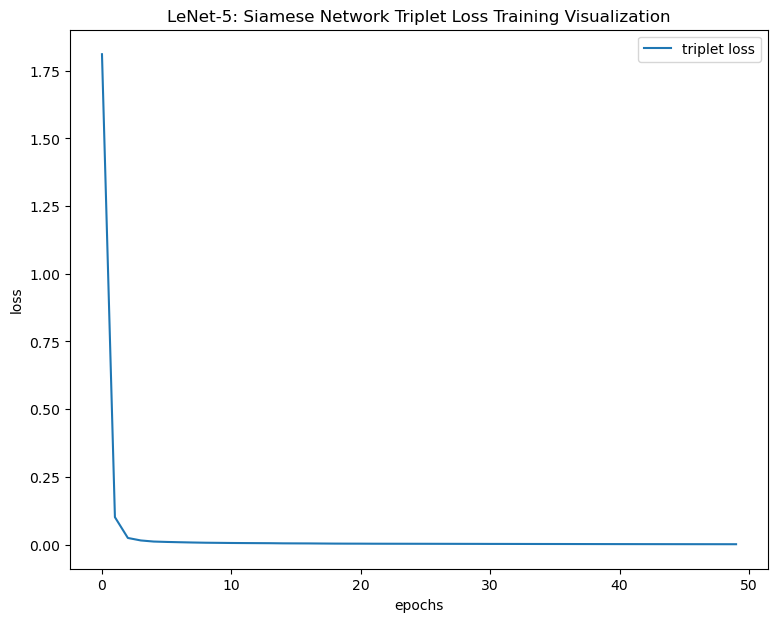

In [25]:
plt.figure(figsize = (9, 7))        
plt.plot([train_history[e]['train_triplet_cost'] for e in train_history.keys()], label = 'triplet loss')
# plt.plot([train_history[e]['val_triplet_cost'] for e in train_history.keys()], label = 'val triplet loss')
plt.title("LeNet-5: Siamese Network Triplet Loss Training Visualization")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

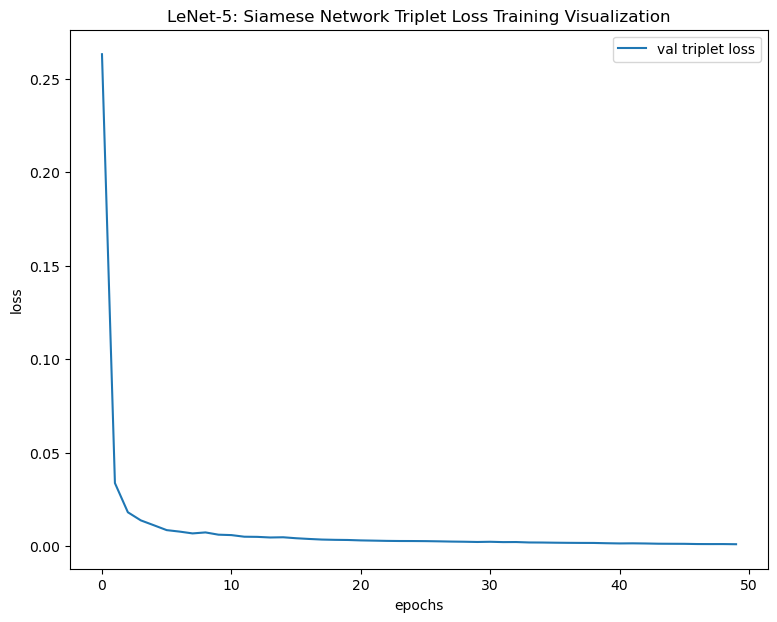

In [24]:
plt.figure(figsize = (9, 7))        
# plt.plot([train_history[e]['train_triplet_cost'] for e in train_history.keys()], label = 'triplet loss')
plt.plot([train_history[e]['val_triplet_cost'] for e in train_history.keys()], label = 'val triplet loss')
plt.title("LeNet-5: Siamese Network Triplet Loss Training Visualization")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Sanity check: for a batch of validation samples, compute pairwise distances

In [52]:
A_t, P_t, N_t = next(iter(test_loader))

In [53]:
A_t_embed = model(A_t)
P_t_embed = model(P_t)
N_t_embed = model(N_t)

In [54]:
tl_val = compute_triplet_loss(A_embed = A_t_embed, P_embed = P_t_embed, N_embed = N_t_embed)

In [55]:
tl_val.item()

0.21448253095149994

In [56]:
dist_pos = (A_t_embed - P_t_embed).pow(2).sum(dim = 1)
dist_neg = (A_t_embed - N_t_embed).pow(2).sum(dim = 1)

In [59]:
dist_pos.min().item(), dist_pos.max().item()

(0.0011988425394520164, 7.888952255249023)

In [60]:
dist_neg.min().item(), dist_neg.max().item()

(0.06719328463077545, 13.763280868530273)

In [61]:
del A_t, A_t_embed, P_t, P_t_embed, N_t, N_t_embed, dist_pos, dist_neg

In [29]:
val_img_embeddings = []

In [30]:
for img, _, _ in test_loader:
    img_emb = model(img)
    val_img_embeddings.append(img_emb.cpu().detach().numpy())

In [32]:
val_img_embeddings = np.vstack(val_img_embeddings)

In [33]:
val_img_embeddings.shape

(10000, 20)

In [47]:
import umap
from sklearn.manifold import TSNE
import plotly.express as px

In [44]:
umap_model = umap.UMAP(
    n_neighbors = 15, min_dist = 0.0,
    n_components = 3, metric = 'euclidean'
)

In [48]:
tsne_model = TSNE(
    n_components = 3, perplexity = 30.0,
    early_exaggeration = 12.0, learning_rate = 'auto',
    n_iter = 1000, n_iter_without_progress = 300,
    min_grad_norm = 1e-07, metric = 'euclidean'
)

In [45]:
val_img_embeddings_lowd = umap_model.fit_transform(val_img_embeddings)

In [49]:
val_img_embeddings_lowd_tsne = tsne_model.fit_transform(val_img_embeddings)

/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [38]:
val_img_embeddings.shape, val_img_embeddings_lowd.shape

((10000, 20), (10000, 3))

In [ ]:
fig = px.scatter_3d(
    x = val_img_embeddings_lowd_tsne[:, 0], y = val_img_embeddings_lowd_tsne[:, 1],
    z = val_img_embeddings_lowd_tsne[:, 2],
    # color = 'species',
    width = 800, height = 500
)
fig.show()